# Project 02

## Trishita Nath

## Project Overview

Using any of the three classifiers described in chapter 6 of Natural Language Processing with Python, and any features you can think of, build the best name gender classifier you can. Begin by splitting the Names Corpus into three subsets: 500 words for the test set, 500 words for the dev-test set, and the remaining 6900 words for the training set. Then, starting with the example name gender classifier, make incremental improvements. Use the dev-test set to check your progress. Once you are satisfied with your classifier, check its final performance on the test set. How does the performance on the test set compare to the performance on the dev-test set? Is this what you'd expect?


## Data Loading

In [71]:
# Load packages
import sys
!{sys.executable} -m pip install -U nltk==3.7
import random
from collections import Counter
import nltk
from nltk import download
from nltk.corpus import names
from nltk.util import ngrams
#from nltk.tokenize.sonority_sequencing import SyllableTokenizer
from nltk import word_tokenize
from nltk.tokenize import SyllableTokenizer
#from nltk.tokenize import *
from nltk import NaiveBayesClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re

import pandas as pd
import numpy as np

# jupyter setup
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [72]:
nltk.__version__

'3.7'

In [73]:
# .
# loading the corpus into memory
download('names')
# convert names to lowercase for easy recognition
males = [name.lower().strip() for name in names.words('male.txt')]
females = [name.lower().strip() for name in names.words('female.txt')]

#Remove unisex names from each list to avoid compromising accuracy of the model

unisex = list(set(males) & set(females))
[males.remove(name) for name in unisex]
[females.remove(name) for name in unisex]

# Add sex labels to the names.
males = [(name,'male') for name in males]
females = [(name,'female') for name in females]

# combine lists of names
all_names = males + females

# Randomize the names to ensure the training/test sets contain both genders
random.seed(13)
random.shuffle(all_names)

[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Package names is already up-to-date!


True

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

## Feature Creation

In [74]:
# Load the data into Pandas Datafame
data = pd.DataFrame.from_dict(dict(all_names), orient='index', columns=['gender']).reset_index()
data.columns = ['name', 'gender']
data.tail(10)

,name,gender
7201,lorie,female
7202,rodrick,male
7203,leta,female
7204,mort,male
7205,tobi,female
7206,samara,female
7207,malorie,female
7208,mandy,female
7209,voltaire,male
7210,stearn,male


In [75]:
# instatiate syllable tokenize
tk= SyllableTokenizer()

# create various feature columns for exploration
data['length'] = data['name'].str.len()
data['first_letter'] = data['name'].str[0]
data['last_letter'] = data['name'].str[-1]
data['vowel_last_letter'] = data['last_letter'].isin([*'aeiou'])
data['vowel_first_letter'] = data['first_letter'].isin([*'aeiou'])
data['vowels'] = data['name'].str.replace(r'[^aeiou]', '')
data['consonants'] = data['name'].str.replace(r'[aeiou]', '')
data['vowel_count'] = data['vowels'].str.len()
data['consonant_count'] = data['consonants'].str.len()
data['bigrams'] = data['name'].apply(lambda x: list(ngrams(x, 2)))
data['trigrams'] = data['name'].apply(lambda x: list(ngrams(x, 3)))
data['syllables'] = data['name'].apply(lambda x: len(tk.tokenize(x)))

# preview data
data.tail()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/nltk/tokenize/sonority_sequencing.py:104: UserWarning: Character not defined in sonority_hierarchy, assigning as vowel: ' '
  " assigning as vowel: '{}'".format(c)


,name,gender,length,first_letter,last_letter,vowel_last_letter,vowel_first_letter,vowels,consonants,vowel_count,consonant_count,bigrams,trigrams,syllables
7206,samara,female,6,s,a,True,False,aaa,smr,3,3,"[(s, a), (a, m), (m, a), (a, r), (r, a)]","[(s, a, m), (a, m, a), (m, a, r), (a, r, a)]",3
7207,malorie,female,7,m,e,True,False,aoie,mlr,4,3,"[(m, a), (a, l), (l, o), (o, r), (r, i), (i, e)]","[(m, a, l), (a, l, o), (l, o, r), (o, r, i), (...",3
7208,mandy,female,5,m,y,False,False,a,mndy,1,4,"[(m, a), (a, n), (n, d), (d, y)]","[(m, a, n), (a, n, d), (n, d, y)]",2
7209,voltaire,male,8,v,e,True,False,oaie,vltr,4,4,"[(v, o), (o, l), (l, t), (t, a), (a, i), (i, r...","[(v, o, l), (o, l, t), (l, t, a), (t, a, i), (...",3
7210,stearn,male,6,s,n,False,False,ea,strn,2,4,"[(s, t), (t, e), (e, a), (a, r), (r, n)]","[(s, t, e), (t, e, a), (e, a, r), (a, r, n)]",1


In [76]:
# Get the most common ngrams by gender through analysis of the bigrams and trigrams columns
ngrams_gender = data.groupby('gender')[['bigrams', 'trigrams']].sum()
ngrams_gender['bigrams_counter'] = ngrams_gender['bigrams'].apply(lambda x: Counter(x))
ngrams_gender['trigrams_counter'] = ngrams_gender['trigrams'].apply(lambda x: Counter(x))
ngrams_gender

,bigrams,trigrams,bigrams_counter,trigrams_counter
gender,,,,
female,"[(p, e), (e, g), (g, g), (g, y), (m, a), (a, y...","[(p, e, g), (e, g, g), (g, g, y), (m, a, y), (...","{('p', 'e'): 39, ('e', 'g'): 22, ('g', 'g'): 1...","{('p', 'e', 'g'): 5, ('e', 'g', 'g'): 8, ('g',..."
male,"[(l, e), (e, s), (s, t), (t, e), (e, r), (r, i...","[(l, e, s), (e, s, t), (s, t, e), (t, e, r), (...","{('l', 'e'): 168, ('e', 's'): 72, ('s', 't'): ...","{('l', 'e', 's'): 12, ('e', 's', 't'): 22, ('s..."


## Data Exploration

Visual and computation exploration of whether the features created are good predictors of gender.

In [77]:
# Some summary statistics
data.groupby('gender').mean()

,length,vowel_last_letter,vowel_first_letter,vowel_count,consonant_count,syllables
gender,,,,,,
female,6.186920,0.737319,0.176344,2.701705,3.485215,2.498165
male,5.995733,0.224593,0.159426,2.221102,3.774631,2.061676


On average, females have a higher name length, higher vowel counts, and the last letter is 73% of the time a vowel. These seem to be good predictors.

In [78]:
# separating features from label
X = data.drop(columns=['name', 'gender'])
y = data['gender']

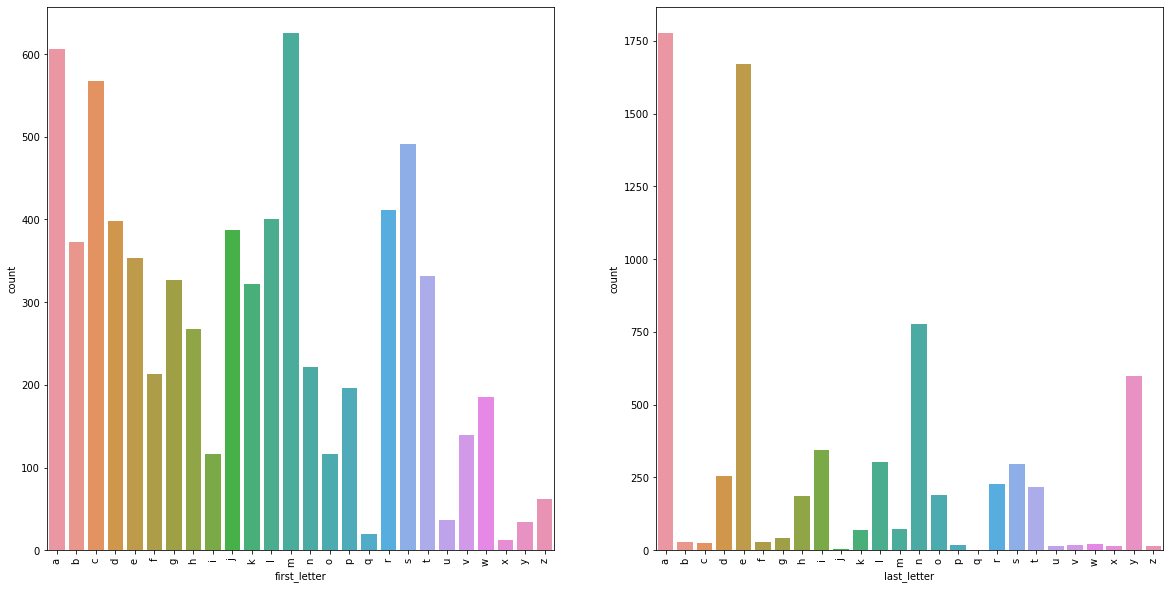

In [79]:
# categorical and numerical columns
categorical_cols = X.loc[:, [col for col in X.columns if 'gram' not in col]].select_dtypes(include='object').columns
numerical_cols = X.select_dtypes(include=np.number).columns

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

for var, subplot in zip(categorical_cols[:2], ax.flatten()):
    sns.countplot(x=var, data=data, ax=subplot,order = list(string.ascii_lowercase))
    # rotate labels for easy viewing
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

Plt based on gender

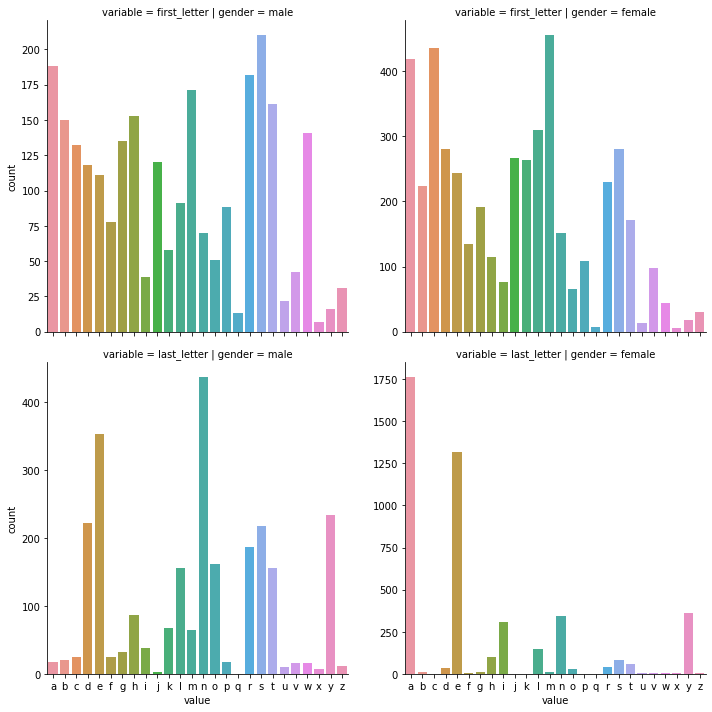

In [80]:
data_melted = pd.melt(data[['gender','first_letter','last_letter']],id_vars=['gender'])

sns.catplot(x = 'value',col='gender',row='variable',kind='count',data=data_melted,
            order = list(string.ascii_lowercase),
            sharey = False)

plt.show()

Both the first and the last letter appear to be good predictors for gender.

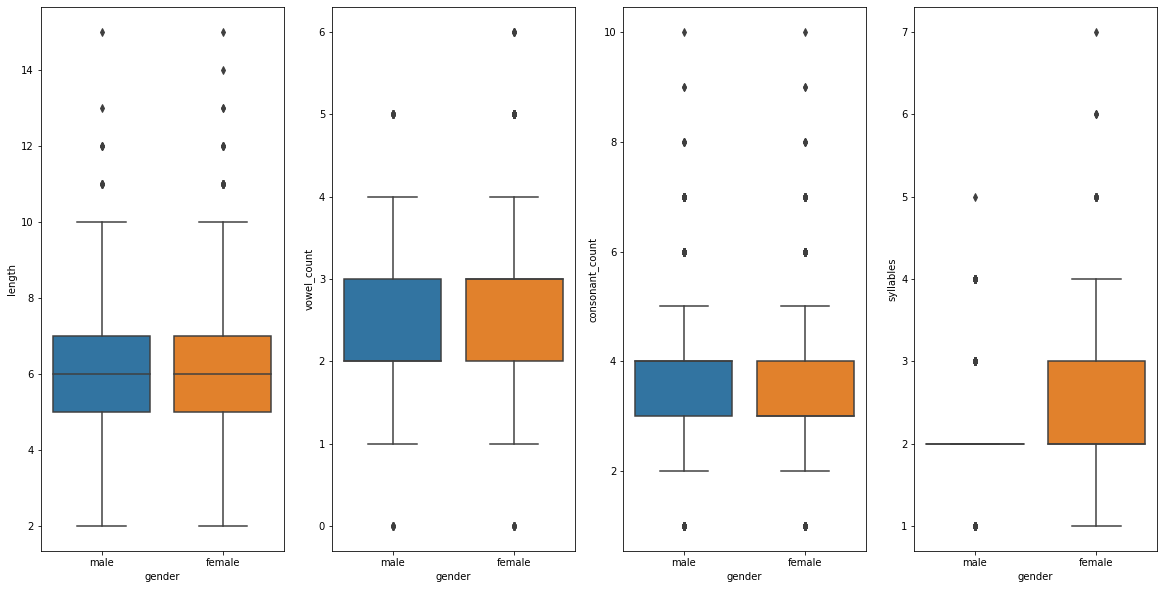

In [81]:
# gender exploration based on numerical columns
fig, ax = plt.subplots(1, 4, figsize=(20, 10))
for var, subplot in zip(numerical_cols, ax.flatten()):
    sns.boxplot(x='gender', y=var, data=data, ax=subplot)

From the above boxplots above, syllables seem to be a good predictor. Also consonant length, count and vowel count can be ruled out of the predictors list.

I will confirm these using count plots below:

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3806: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


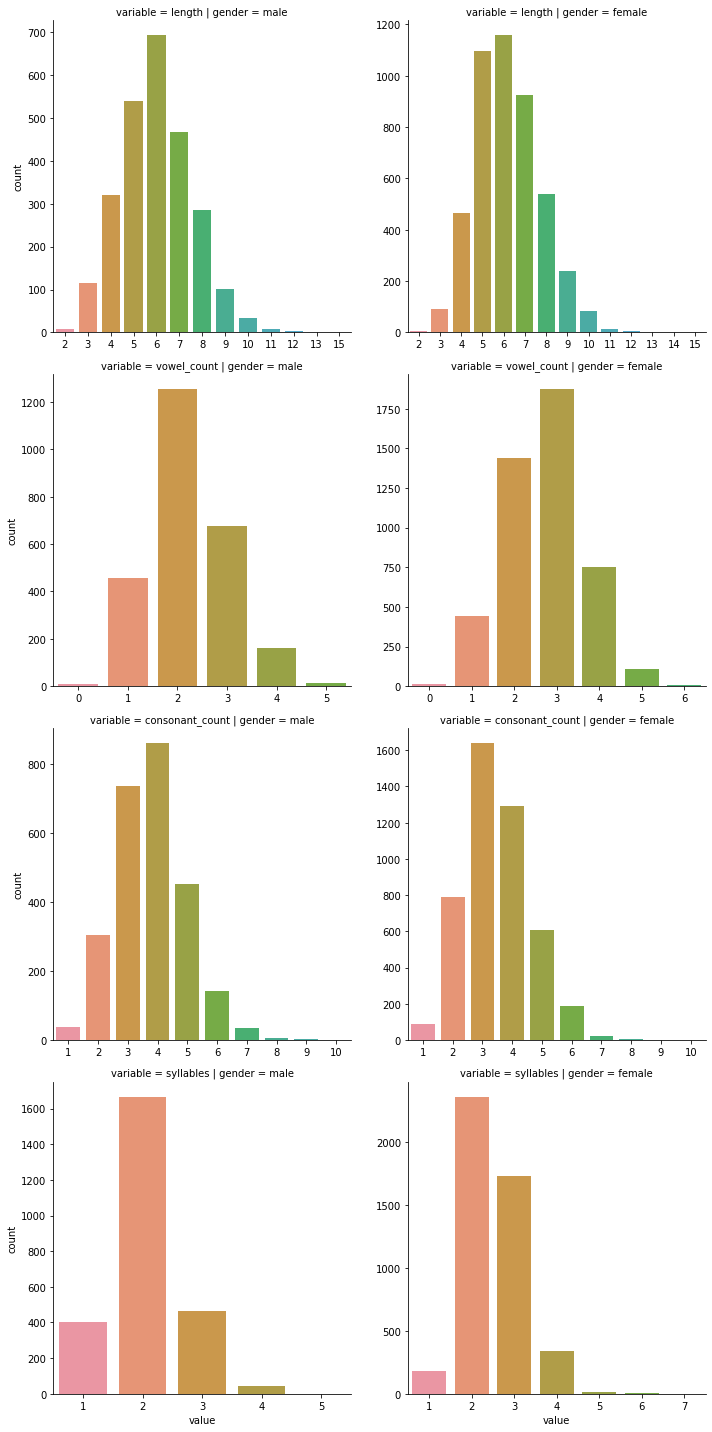

In [82]:
data_melted = pd.melt(data[['gender','length','vowel_count','consonant_count','syllables']],id_vars=['gender'])

sns.catplot(x = 'value',col='gender',row='variable',kind='count',data=data_melted,
            sharey = False,sharex=False)
plt.show()

The previous conclusion still holds: we can exclude length, consonant count, and vowel count.


## Feature generation

I will apply the feature generation function below to the lists of names to create the features identified as potential gender predictors. I have removed length, vowel count and consonant count.



In [83]:
# Feature generation function
def gender_features(name):
    
    # last letter, first letter, vowel last/first letter
    first_letter = name[0]
    vowel_first_letter = first_letter in 'aeiou'
    last_letter = name[-1]
    vowel_last_letter = last_letter in 'aeiou'
    
    # vowels/consonants
    vowels = "".join(sorted(list(set(re.sub(r'[^aeiou]', '', name)))))
    consonants = "".join(sorted(list(set(re.sub(r'[aeiou]', '', name)))))
    
    # bigrams/trigrams
    bigrams = (ngrams(name, 2))
    trigrams = (ngrams(name, 3))
    
    # syllables
    syllables = len(tk.tokenize(name))
    
    return {
        'first_letter': first_letter,
        'vowel_first_letter': vowel_first_letter,
        'last_letter': last_letter,
        'vowel_last_letter': vowel_last_letter,
        'vowels': vowels,
        'consonants': consonants,
        'bigrams': bigrams,
        'trigrams': trigrams,
        'syllables': syllables
    }

### Data Preparation

Training, Splitting and applying feature generation function.

In [84]:

# create the sets of data
num_remaining = len(all_names) - 500
training_and_dev_test = all_names[-num_remaining:]

#Separate the training and dev test data.
#We will call these "dev_test1" and "training1".

dev_test1 = training_and_dev_test[:500]
training1 = training_and_dev_test[500:]

#Shuffle to create four additional training vs. dev-test splits.

random.shuffle(training_and_dev_test)
dev_test2 = training_and_dev_test[:500]
training2 = training_and_dev_test[500:]

random.shuffle(training_and_dev_test)
dev_test3 = training_and_dev_test[:500]
training3 = training_and_dev_test[500:]

random.shuffle(training_and_dev_test)
dev_test4 = training_and_dev_test[:500]
training4 = training_and_dev_test[500:]

random.shuffle(training_and_dev_test)
dev_test5 = training_and_dev_test[:500]
training5 = training_and_dev_test[500:]

# apply feature generation function
dev_test_features1 = [(gender_features(name), gender) for name, gender in dev_test1]
training_features1 = [(gender_features(name), gender) for name, gender in training1]

dev_test_features2 = [(gender_features(name), gender) for name, gender in dev_test2]
training_features2 = [(gender_features(name), gender) for name, gender in training2]

dev_test_features3 = [(gender_features(name), gender) for name, gender in dev_test3]
training_features3 = [(gender_features(name), gender) for name, gender in training3]

dev_test_features4 = [(gender_features(name), gender) for name, gender in dev_test4]
training_features4 = [(gender_features(name), gender) for name, gender in training4]

dev_test_features5 = [(gender_features(name), gender) for name, gender in dev_test5]
training_features5 = [(gender_features(name), gender) for name, gender in training5]



/usr/local/lib/python3.7/dist-packages/nltk/tokenize/sonority_sequencing.py:104: UserWarning: Character not defined in sonority_hierarchy, assigning as vowel: ' '
  " assigning as vowel: '{}'".format(c)


## Modelling

I will use the maximum entropy model

In [85]:
classifier1v1 = nltk.MaxentClassifier.train(training_features1,trace=1)
classifier2v1 = nltk.MaxentClassifier.train(training_features2,trace=1)
classifier3v1 = nltk.MaxentClassifier.train(training_features3,trace=1)
classifier4v1 = nltk.MaxentClassifier.train(training_features4,trace=1)
classifier5v1 = nltk.MaxentClassifier.train(training_features5,trace=1)

  ==> Training (100 iterations)
  ==> Training (100 iterations)
  ==> Training (100 iterations)
  ==> Training (100 iterations)
  ==> Training (100 iterations)


Model accuracy on dev_test data

In [86]:
nltk.classify.accuracy(classifier1v1, dev_test_features1)
print()
nltk.classify.accuracy(classifier2v1, dev_test_features2)
print()
nltk.classify.accuracy(classifier3v1, dev_test_features3)
print()
nltk.classify.accuracy(classifier4v1, dev_test_features4)
print()
nltk.classify.accuracy(classifier5v1, dev_test_features5)



0.846

0.838

0.816

0.834

0.85

### Model Refining

Accuracy can be improved by either adding new features, or removing those features that are not predictive. This can be done by first examining the errors.

In [87]:
errors = []

for (name,tag) in dev_test1:
    guess = classifier1v1.classify(gender_features(name))
    if guess != tag:
        errors.append((tag,guess,name))

for (tag,guess,name) in sorted(errors):
    print('correct={:<8} guess={:<8s} name={:30}'.format(tag,guess,name))

correct=female   guess=male     name=aggy                          
correct=female   guess=male     name=aurel                         
correct=female   guess=male     name=beatriz                       
correct=female   guess=male     name=becky                         
correct=female   guess=male     name=bell                          
correct=female   guess=male     name=betteann                      
correct=female   guess=male     name=bren                          
correct=female   guess=male     name=brittan                       
correct=female   guess=male     name=candis                        
correct=female   guess=male     name=damaris                       
correct=female   guess=male     name=darell                        
correct=female   guess=male     name=daryn                         
correct=female   guess=male     name=dove                          
correct=female   guess=male     name=eryn                          
correct=female   guess=male     name=ester      

Names incorrectly guessed i.e male names guesed as females, and vice-versa

In [88]:
actually_female_guessed_incorrectly = []
actually_male_guessed_incorrectly = []

for (tag,guess,name) in sorted(errors):
    if tag == "female":
        actually_female_guessed_incorrectly.append(name)
    if tag == "male":
        actually_male_guessed_incorrectly.append(name)

print("First letter count errors, actually female then actually male:")
Counter([name[0] for name in actually_female_guessed_incorrectly])
Counter([name[0] for name in actually_male_guessed_incorrectly])
print("First letter vowel count errors:")
Counter([name[0] in 'aeiou' for name in actually_female_guessed_incorrectly])
Counter([name[0] in 'aeiou' for name in actually_male_guessed_incorrectly])
print("Last letter count errors:")
Counter([name[-1] for name in actually_female_guessed_incorrectly])
Counter([name[-1] for name in actually_male_guessed_incorrectly])
print("Last letter vowel count errors:")
Counter([name[-1] in 'aeiou' for name in actually_female_guessed_incorrectly])
Counter([name[-1] in 'aeiou' for name in actually_male_guessed_incorrectly])
print("List of vowels count errors:")
Counter(["".join(sorted(list(set(re.sub(r'[^aeiou]', '', name))))) for name in actually_female_guessed_incorrectly])
Counter(["".join(sorted(list(set(re.sub(r'[^aeiou]', '', name))))) for name in actually_male_guessed_incorrectly])

First letter count errors, actually female then actually male:


Counter({'a': 2,
         'b': 6,
         'c': 1,
         'd': 4,
         'e': 2,
         'g': 1,
         'h': 3,
         'j': 3,
         'm': 1,
         'n': 1,
         'o': 1,
         'r': 3,
         's': 2,
         'w': 1,
         'y': 1})

Counter({'a': 4,
         'b': 2,
         'c': 1,
         'd': 3,
         'f': 1,
         'g': 5,
         'h': 2,
         'i': 1,
         'j': 4,
         'k': 1,
         'm': 4,
         'n': 3,
         'o': 1,
         'p': 2,
         'r': 1,
         's': 4,
         't': 2,
         'v': 3,
         'z': 1})

First letter vowel count errors:


Counter({False: 27, True: 5})

Counter({False: 39, True: 6})

Last letter count errors:


Counter({'d': 3,
         'e': 1,
         'h': 2,
         'l': 6,
         'n': 7,
         'r': 2,
         's': 3,
         't': 1,
         'y': 6,
         'z': 1})

Counter({'a': 1, 'c': 1, 'e': 21, 'h': 2, 'l': 2, 'n': 7, 's': 1, 'y': 10})

Last letter vowel count errors:


Counter({False: 31, True: 1})

Counter({False: 23, True: 22})

List of vowels count errors:


Counter({'a': 4,
         'ae': 3,
         'aei': 2,
         'aeo': 2,
         'aeu': 1,
         'ai': 4,
         'ao': 3,
         'e': 7,
         'ei': 1,
         'eo': 3,
         'eu': 1,
         'i': 1})

Counter({'': 2,
         'a': 5,
         'ae': 5,
         'aei': 6,
         'aeo': 1,
         'ai': 3,
         'aiu': 1,
         'e': 9,
         'ei': 5,
         'eio': 2,
         'eiu': 1,
         'eo': 5})

It appears incorrectly guessed male names often end in "e". These seem to likely contain an "a" and or "e". Lets check for these names in males vs females in the raining data

In [89]:
def vowels(name):
    return "".join(sorted(list(set(re.sub(r'[^aeiou]', '', name)))))

Counter([list(name).count('a') >= 1 for name,tag in training1 if tag == "female"])
print()
Counter([list(name).count('a') >= 1 for name,tag in training1 if tag == "male"])
print()
Counter([list(name).count('e') >= 1 for name,tag in training1 if tag == "female"])
print()
Counter([list(name).count('e') >= 1 for name,tag in training1 if tag == "male"])

Counter({False: 1230, True: 2758})

Counter({False: 1100, True: 1126})

Counter({False: 1555, True: 2433})

Counter({False: 1031, True: 1195})

Females have higher chance of having an 'a' and/or an 'e' in their name; this might be the reason why males with these vowels in their name are guessed as females. Just like in the textbook, I will add a second suffix to srr if the accuracy of the model improves.

In [90]:
def gender_features(name):
    
    # last letter, first letter, vowel last/first letter
    first_letter = name[0]
    vowel_first_letter = first_letter in 'aeiou'
    last_letter = name[-1]
    last_two_letters = name[-2:]
    vowel_last_letter = last_letter in 'aeiou'
    
    # vowels/consonants
    vowels = "".join(sorted(list(set(re.sub(r'[^aeiou]', '', name)))))
    consonants = "".join(sorted(list(set(re.sub(r'[aeiou]', '', name)))))
    
    # bigrams/trigrams
    bigrams = (ngrams(name, 2))
    trigrams = (ngrams(name, 3))
    
    # syllables
    syllables = len(tk.tokenize(name))
    
    return {
        'first_letter': first_letter,
        'vowel_first_letter': vowel_first_letter,
        'last_letter': last_letter,
        'last_two_letters': last_two_letters,
        'vowel_last_letter': vowel_last_letter,
        'vowels': vowels,
        'consonants': consonants,
        'bigrams': bigrams,
        'trigrams': trigrams,
        'syllables': syllables
    }

dev_test_features1 = [(gender_features(name), gender) for name, gender in dev_test1]
training_features1 = [(gender_features(name), gender) for name, gender in training1]

dev_test_features2 = [(gender_features(name), gender) for name, gender in dev_test2]
training_features2 = [(gender_features(name), gender) for name, gender in training2]

dev_test_features3 = [(gender_features(name), gender) for name, gender in dev_test3]
training_features3 = [(gender_features(name), gender) for name, gender in training3]

dev_test_features4 = [(gender_features(name), gender) for name, gender in dev_test4]
training_features4 = [(gender_features(name), gender) for name, gender in training4]

dev_test_features5 = [(gender_features(name), gender) for name, gender in dev_test5]
training_features5 = [(gender_features(name), gender) for name, gender in training5]



/usr/local/lib/python3.7/dist-packages/nltk/tokenize/sonority_sequencing.py:104: UserWarning: Character not defined in sonority_hierarchy, assigning as vowel: ' '
  " assigning as vowel: '{}'".format(c)


Accuracy

In [91]:
classifier1v2 = nltk.MaxentClassifier.train(training_features1,trace=1)
classifier2v2 = nltk.MaxentClassifier.train(training_features2,trace=1)
classifier3v2 = nltk.MaxentClassifier.train(training_features3,trace=1)
classifier4v2 = nltk.MaxentClassifier.train(training_features4,trace=1)
classifier5v2 = nltk.MaxentClassifier.train(training_features5,trace=1)

nltk.classify.accuracy(classifier1v2, dev_test_features1)
print()
nltk.classify.accuracy(classifier2v2, dev_test_features2)
print()
nltk.classify.accuracy(classifier3v2, dev_test_features3)
print()
nltk.classify.accuracy(classifier4v2, dev_test_features4)
print()
nltk.classify.accuracy(classifier5v2, dev_test_features5)



  ==> Training (100 iterations)
  ==> Training (100 iterations)
  ==> Training (100 iterations)
  ==> Training (100 iterations)
  ==> Training (100 iterations)


0.848

0.84

0.842

0.834

0.856

There is accuracy improvement in some cases

## Model Evaluation

### Accuracy

Accuracy of the model based on the final test data including all the initially chosen variables.

In [92]:
def gender_features(name):
    
    # last letter, first letter, vowel last/first letter
    first_letter = name[0]
    vowel_first_letter = first_letter in 'aeiou'
    last_letter = name[-1]
    vowel_last_letter = last_letter in 'aeiou'
    
    # vowels/consonants
    vowels = "".join(sorted(list(set(re.sub(r'[^aeiou]', '', name)))))
    consonants = "".join(sorted(list(set(re.sub(r'[aeiou]', '', name)))))
    
    # bigrams/trigrams
    bigrams = (ngrams(name, 2))
    trigrams = (ngrams(name, 3))
    
    # syllables
    syllables = len(tk.tokenize(name))
    
    return {
        'first_letter': first_letter,
        'vowel_first_letter': vowel_first_letter,
        'last_letter': last_letter,
        'vowel_last_letter': vowel_last_letter,
        'vowels': vowels,
        'consonants': consonants,
        'bigrams': bigrams,
        'trigrams': trigrams,
        'syllables': syllables
    }

final_test_features = [(gender_features(name), gender) for name, gender in final_test]

nltk.classify.accuracy(classifier1v1, final_test_features)
print()
nltk.classify.accuracy(classifier2v1, final_test_features)
print()
nltk.classify.accuracy(classifier3v1, final_test_features)
print()
nltk.classify.accuracy(classifier4v1, final_test_features)
print()
nltk.classify.accuracy(classifier5v1, final_test_features)

0.806

0.802

0.798

0.8

0.81

Accuracy ranges from 79.8 - 81% on the final test data using all features